## RainFall Data Analysis

In [2]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

### Download Partitioned Data

In [2]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "../data/rainfall/partitions/"


# Retrieve the article metadata
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want


# Zip to Folder Unzip
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])
        
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

### Combine Data

In [4]:
%%time
# Read the data
output_directory = "../data/rainfall/partitions/"
files_to_combine = glob.glob(output_directory + "*.csv")
files_to_combine.remove(output_directory + "observed_daily_rainfall_SYD.csv")
df = pd.concat(
    (pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'[^\/&\\]+(?=_daily_rainfall_NSW\.)', file)[0])
                for file in files_to_combine)
    )

# Save the combined data
data_path = "../data/rainfall/"
os.makedirs(data_path + "combined/", exist_ok=True)
df.to_csv(data_path + "combined/rainfall_data.csv")


KeyboardInterrupt: 

### Loading Combined Data and Simple EDA

In [5]:
# Read the data
data = pd.read_csv("../data/rainfall/combined/rainfall_data.csv")

In [5]:
# Testing different loading methods for EDA timing
import sys
# size of 'data' in gigabytes
sys.getsizeof(data)/(1e9)

11.448609766

In [6]:
data.dtypes

time              object
lat_min          float64
lat_max          float64
lon_min          float64
lon_max          float64
rain (mm/day)    float64
model             object
dtype: object

#### No data manipulation

In [7]:
%%timeit -n 3 -r 2 # run statement 3 times for 2 repetitions
data.value_counts()

data.describe()

data.nunique()

1min 51s ± 312 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


#### Modifying Data Types

In [8]:
# Changing data types
## Changed 'time' from `object` to `datetime.datetime`
data['time'] = pd.to_datetime(data['time'])
data[['lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']] = data[['lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']].astype('float32')
sys.getsizeof(data)/(1e9) #size of modified data in GB

5.963029062

In [9]:
%%timeit -n 3 -r 2 # run statement 3 times for 2 repetitions
data.value_counts()

data.describe()

data.nunique()

1min 36s ± 121 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


#### Loading Select Columns

In [10]:
# CLEAR MODIFIED DATAFRAME AND RELOAD
del data

data = pd.read_csv("../data/rainfall/combined/rainfall_data.csv")

In [11]:
# Using only necessary columns (time, rainfall, model), location columns can be loaded in later if needed

data = data[['time', 'rain (mm/day)', 'model']]
sys.getsizeof(data)/(1e9) # Very interesting to see here, the location columns account for only ~10% of the total object size

9.44963879

In [12]:
%%timeit -n 3 -r 2 # run statement 3 times for 2 repetitions
data.value_counts()

data.describe()

data.nunique()

1min 10s ± 188 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


# Perform EDA on Python

In [7]:
# convert time to datetime year only
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year
# group data by year and model
data_grouped = data.groupby(['year', 'model']).mean()
data_grouped.reset_index(inplace=True)

model_list = ['ACCESS-CM2', 'ACCESS-ESM1-5'] # list of models to plot
data_filtered = data_grouped[data_grouped['model'].isin(model_list)]
data_filtered.head()


,year,model,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
0,1889,ACCESS-CM2,-33.125,-31.875,146.25,148.125,1.398767
10,1890,ACCESS-CM2,-33.125,-31.875,146.25,148.125,1.488712
20,1891,ACCESS-CM2,-33.125,-31.875,146.25,148.125,2.198307
30,1892,ACCESS-CM2,-33.125,-31.875,146.25,148.125,2.044209
40,1893,ACCESS-CM2,-33.125,-31.875,146.25,148.125,1.866341


In [19]:
# plot the data and facet by model
import altair as alt
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()
alt.Chart(data_filtered).mark_line().encode(
    x='year',
    y='rain (mm/day):Q',
    color='model:N'
).properties(
    width=400,
    height=200
).facet(
    row='model:N'
).interactive()


<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


#### Conclusion and Discussion

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken for Each Type of Memory Reduction |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Sam   |    macOS Catalina      |16GB | 2.8 GHz 4 Core i7   |  Yes   | 3mins, 2.5mins, 1.9mins     |
| Member 2    |                  |     |           |        |            |
| Member 3    |                  |     |           |        |            |
| Member 4    |                  |     |           |        |            |

I attempted to show some plots but unless I loaded only parts of the dataset, they would not execute. In terms of memory space, changing the data types was the best at reducing the size of the object. This is due to the changing of the numerical data from float64 to float32, which is effectively half the space. The trade-off for doing this is that now our data is less precise than before.

## Transform data from Python to R

In [15]:
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra
%load_ext rpy2.ipython

In [16]:
%%R
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(ggplot2, warn.conflicts = FALSE))

In [17]:
%%time
# read in the data
df = pd.read_csv("../data/rainfall/combined/rainfall_data.csv")

CPU times: user 40.3 s, sys: 9.3 s, total: 49.6 s
Wall time: 54.3 s


### Feather

In [18]:
%%time
# save the data to feather
df.to_feather(data_path +"combined/rainfall_data.feather")

CPU times: user 7.3 s, sys: 5.34 s, total: 12.6 s
Wall time: 8.37 s


In [19]:
%%time
%%R
# open the feather file from R
ds <- open_dataset("../data/rainfall/combined/rainfall_data.feather", format="feather")

CPU times: user 7.6 ms, sys: 12.4 ms, total: 20 ms
Wall time: 163 ms


In [20]:
%%time
%%R
# print the data in R
print(ds %>% collect)

# A tibble: 62,467,843 × 7
   time                lat_min lat_max lon_min lon_max `rain (mm/day)` model    
   <chr>                 <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>    
 1 1889-01-01 12:00:00   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-…
 2 1889-01-02 12:00:00   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-…
 3 1889-01-03 12:00:00   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-…
 4 1889-01-04 12:00:00   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-…
 5 1889-01-05 12:00:00   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-…
 6 1889-01-06 12:00:00   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-…
 7 1889-01-07 12:00:00   -35.4   -33.6    142.    143.        4.19e-13 MPI-ESM-…
 8 1889-01-08 12:00:00   -35.4   -33.6    142.    143.        4.56e-13 MPI-ESM-…
 9 1889-01-09 12:00:00   -35.4   -33.6    142.    143.        2.53e+ 0 MPI-ESM-…
10 1889-01-10 12:00:00   -35.4   -33.6    142.    143.        4.12e- 2 MPI-ESM-…
#

### Parquet

In [21]:
%%time
# save to parquet file
df.to_parquet("../data/rainfall/combined/rainfall_data.parquet")

CPU times: user 16.5 s, sys: 5.16 s, total: 21.6 s
Wall time: 22.5 s


In [22]:
%%time
%%R
ds_parquet <- open_dataset("../data/rainfall/combined/rainfall_data.parquet", format="parquet")

CPU times: user 7.02 ms, sys: 9.69 ms, total: 16.7 ms
Wall time: 18.4 ms


In [23]:
%%time
%%R
print(ds_parquet %>% collect)

# A tibble: 62,467,843 × 7
   time                lat_min lat_max lon_min lon_max `rain (mm/day)` model    
   <chr>                 <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>    
 1 1889-01-01 12:00:00   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-…
 2 1889-01-02 12:00:00   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-…
 3 1889-01-03 12:00:00   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-…
 4 1889-01-04 12:00:00   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-…
 5 1889-01-05 12:00:00   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-…
 6 1889-01-06 12:00:00   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-…
 7 1889-01-07 12:00:00   -35.4   -33.6    142.    143.        4.19e-13 MPI-ESM-…
 8 1889-01-08 12:00:00   -35.4   -33.6    142.    143.        4.56e-13 MPI-ESM-…
 9 1889-01-09 12:00:00   -35.4   -33.6    142.    143.        2.53e+ 0 MPI-ESM-…
10 1889-01-10 12:00:00   -35.4   -33.6    142.    143.        4.12e- 2 MPI-ESM-…
#

### Arrow exchange

In [24]:
%%time
dataset = ds.dataset("../data/rainfall/combined/rainfall_data.csv", format="csv")
table = dataset.to_table()
r_table = pyra.converter.py2rpy(table)

CPU times: user 33.7 s, sys: 3.17 s, total: 36.8 s
Wall time: 38.6 s


In [25]:
%%time
%%R -i r_table
start_time <- Sys.time()
suppressMessages(library(dplyr))
result <- r_table 
end_time <- Sys.time()
print(result %>% collect())
print(end_time - start_time)

# A tibble: 62,467,843 × 7
   time                lat_min lat_max lon_min lon_max `rain (mm/day)` model    
   <dttm>                <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>    
 1 1889-01-01 04:00:00   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-…
 2 1889-01-02 04:00:00   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-…
 3 1889-01-03 04:00:00   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-…
 4 1889-01-04 04:00:00   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-…
 5 1889-01-05 04:00:00   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-…
 6 1889-01-06 04:00:00   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-…
 7 1889-01-07 04:00:00   -35.4   -33.6    142.    143.        4.19e-13 MPI-ESM-…
 8 1889-01-08 04:00:00   -35.4   -33.6    142.    143.        4.56e-13 MPI-ESM-…
 9 1889-01-09 04:00:00   -35.4   -33.6    142.    143.        2.53e+ 0 MPI-ESM-…
10 1889-01-10 04:00:00   -35.4   -33.6    142.    143.        4.12e- 2 MPI-ESM-…
#

We tried 4 different approaches, the reason that we chose feather transfer over others is that:
    
- Arrow exchange: It is slower than feather file. It used around 40 seconds on my laptop(M1 Mac 16G RAM).
- Pandas exchange: This approach is the most slow among all methods, I waited about 40 minutes and I gave up because it hadn't stopped running by that time.
- Parquet file: Parquet files are mainly suitable for long term storage whereas feather files are used in short term storage such as dataframe transfers. Besides, in terms of time, transfer pandas dataframe to parquet took much longer time than to feather file. In terms of storage memory, Parquet files is much smaller than Feather files which can save some memory space for long term storage.

## Perform EDA in R

In [26]:
%%R
model_list <- c("ACCESS-CM2", "ACCESS-ESM1-5")

df_filtered <- ds |> filter (model %in% model_list) |>
                rename(rain='rain (mm/day)')|> 
                select(time, rain, model) |> collect()
# convert time to datetime
df_filtered$time <- as.Date(df_filtered$time)

head(df_filtered)

# A tibble: 6 × 3
  time           rain model     
  <date>        <dbl> <chr>     
1 1889-01-01 3.29e-13 ACCESS-CM2
2 1889-01-02 0        ACCESS-CM2
3 1889-01-03 0        ACCESS-CM2
4 1889-01-04 0        ACCESS-CM2
5 1889-01-05 1.05e- 2 ACCESS-CM2
6 1889-01-06 3.29e- 2 ACCESS-CM2


In [27]:
%%R
df_filtered$year <- as.numeric(format(df_filtered$time, "%Y"))
# head(df_filtered)
df_grouped <- df_filtered |> group_by(year, model) |> summarise(rain=mean(rain))
head(df_grouped)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.
# A tibble: 6 × 3
# Groups:   year [3]
   year model          rain
  <dbl> <chr>         <dbl>
1  1889 ACCESS-CM2     1.40
2  1889 ACCESS-ESM1-5  1.86
3  1890 ACCESS-CM2     1.49
4  1890 ACCESS-ESM1-5  1.67
5  1891 ACCESS-CM2     2.20
6  1891 ACCESS-ESM1-5  3.67


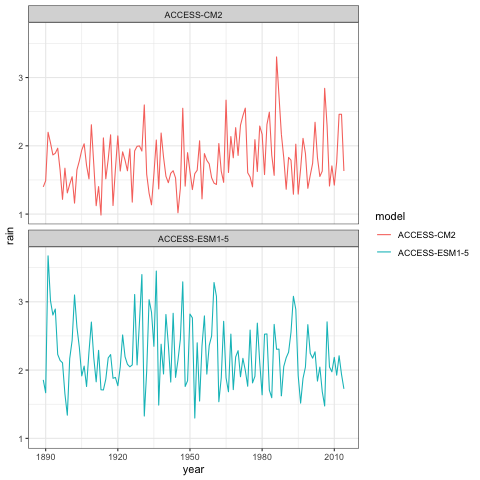

In [28]:
%%R
# plot df_grouped, faceted by model
ggplot(df_grouped, aes(x=year, y=rain, color=model)) +
    geom_line() +
    facet_wrap(~model, ncol=1) +
    theme_bw()